## CartPole-IG Experiment: XRL with IG

### 목적
Captum의 Integrated Gradients를 사용하여 CartPole 에이전트가 어떤 상태 특성에 민감하게 반응하는지 분석하기

### 실험 내용
1. DQN 에이전트 학습
2. Integrated Gradients로 각 상태 변수의 중요도 분석
3. 시간에 따른 변화 비교
4. Action별 패턴 비교
5. 상태별(안정/위기) 비교

## 1. 라이브러리 임포트

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients
from collections import deque
import random

# 재현성을 위한 시드 설정
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("라이브러리 임포트 완료!")
print(f"PyTorch 버전: {torch.__version__}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

라이브러리 임포트 완료!
PyTorch 버전: 2.8.0+cu126
Device: cuda


## 2. DQN 네트워크 정의

CartPole 환경의 4가지 상태 변수:
- Position (카트 위치)
- Velocity (카트 속도)
- Angle (막대 각도)
- Angular Velocity (막대 각속도)

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.network(x)

# 환경 및 네트워크 초기화
env = gym.make('CartPole-v1')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(state_dim, action_dim).to(device)
target_net = DQN(state_dim, action_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())

print(f"State dimension: {state_dim}")
print(f"Action dimension: {action_dim}")
print(f"Network architecture:\n{policy_net}")

State dimension: 4
Action dimension: 2
Network architecture:
DQN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 3. Experience Replay 및 학습 함수

In [4]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))

    def __len__(self):
        return len(self.buffer)

def select_action(state, epsilon):
    """Epsilon-greedy action selection"""
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax(1).item()

def train_step(replay_buffer, batch_size, gamma):
    """Single training step"""
    if len(replay_buffer) < batch_size:
        return None

    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    states = torch.FloatTensor(states).to(device)
    actions = torch.LongTensor(actions).to(device)
    rewards = torch.FloatTensor(rewards).to(device)
    next_states = torch.FloatTensor(next_states).to(device)
    dones = torch.FloatTensor(dones).to(device)

    # Current Q values
    current_q = policy_net(states).gather(1, actions.unsqueeze(1))

    # Target Q values
    with torch.no_grad():
        next_q = target_net(next_states).max(1)[0]
        target_q = rewards + (1 - dones) * gamma * next_q

    # Loss and optimization
    loss = nn.MSELoss()(current_q.squeeze(), target_q)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

print("학습 함수 정의 완료!")

학습 함수 정의 완료!


## 4. DQN 학습

In [5]:
# 하이퍼파라미터
num_episodes = 300
batch_size = 64
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 0.995
target_update = 10
learning_rate = 0.001

# 초기화
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(capacity=10000)
epsilon = epsilon_start
episode_rewards = []
episode_lengths = []

print("학습 시작...")

for episode in range(num_episodes):
    state, _ = env.reset()
    episode_reward = 0
    done = False
    steps = 0

    while not done:
        # Action selection
        action = select_action(state, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store transition
        replay_buffer.push(state, action, reward, next_state, done)

        # Training step
        loss = train_step(replay_buffer, batch_size, gamma)

        state = next_state
        episode_reward += reward
        steps += 1

    episode_rewards.append(episode_reward)
    episode_lengths.append(steps)

    # Epsilon decay
    epsilon = max(epsilon_end, epsilon * epsilon_decay)

    # Target network update
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Logging
    if (episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"Episode {episode+1}/{num_episodes}, Avg Reward: {avg_reward:.2f}, Epsilon: {epsilon:.3f}")

print("\n학습 완료!")
print(f"최근 50 에피소드 평균 보상: {np.mean(episode_rewards[-50:]):.2f}")

학습 시작...
Episode 50/300, Avg Reward: 23.12, Epsilon: 0.778
Episode 100/300, Avg Reward: 45.70, Epsilon: 0.606
Episode 150/300, Avg Reward: 93.88, Epsilon: 0.471
Episode 200/300, Avg Reward: 89.80, Epsilon: 0.367
Episode 250/300, Avg Reward: 114.90, Epsilon: 0.286
Episode 300/300, Avg Reward: 165.66, Epsilon: 0.222

학습 완료!
최근 50 에피소드 평균 보상: 165.66


## 5. 학습 결과 시각화

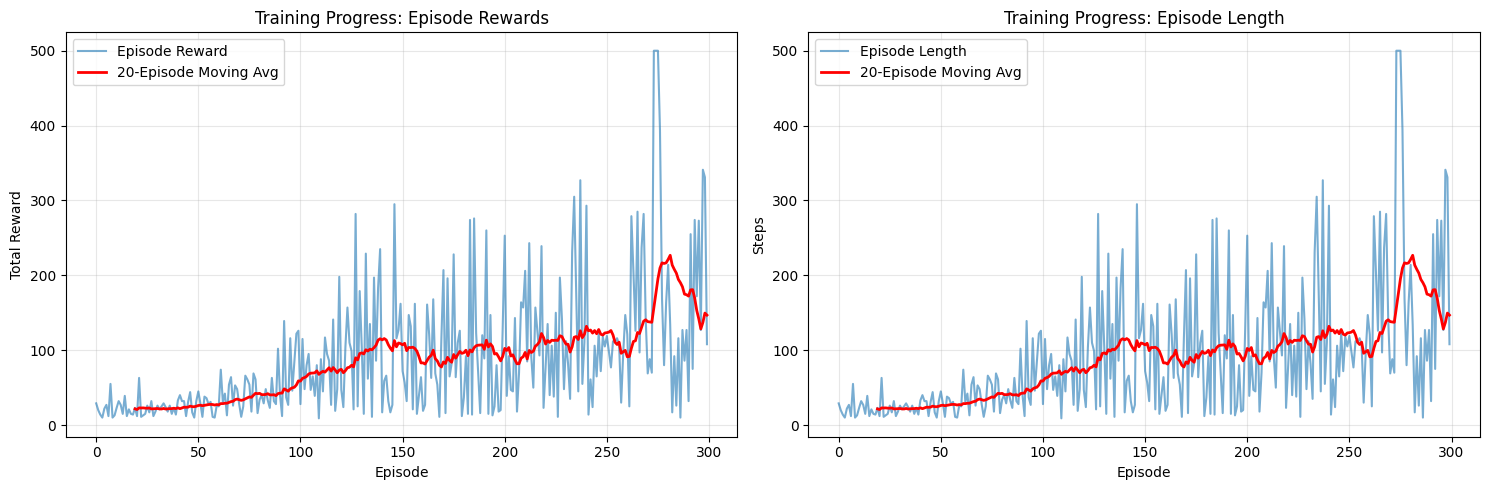

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Episode rewards
ax1.plot(episode_rewards, alpha=0.6, label='Episode Reward')
# Moving average
window = 20
moving_avg = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
ax1.plot(range(window-1, len(episode_rewards)), moving_avg, 'r-', linewidth=2, label=f'{window}-Episode Moving Avg')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Progress: Episode Rewards')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Episode lengths
ax2.plot(episode_lengths, alpha=0.6, label='Episode Length')
moving_avg_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
ax2.plot(range(window-1, len(episode_lengths)), moving_avg_len, 'r-', linewidth=2, label=f'{window}-Episode Moving Avg')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Steps')
ax2.set_title('Training Progress: Episode Length')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Integrated Gradients 준비

Integrated Gradients를 사용하여 각 상태 변수의 중요도를 분석합니다.

In [7]:
# IG를 위한 wrapper 함수 - 특정 action의 Q-value를 반환
def model_forward(state, action_idx):
    """Returns Q-value for a specific action"""
    q_values = policy_net(state)
    return q_values[:, action_idx]

# Integrated Gradients 초기화
ig = IntegratedGradients(model_forward)

# 베이스라인: 모든 상태가 0인 상태
baseline = torch.zeros(1, state_dim).to(device)

print("Integrated Gradients 준비 완료!")
print(f"Baseline shape: {baseline.shape}")

# 상태 변수 이름
feature_names = ['Cart Position', 'Cart Velocity', 'Pole Angle', 'Pole Angular Velocity']

Integrated Gradients 준비 완료!
Baseline shape: torch.Size([1, 4])


## 7. 샘플 상태 수집

다양한 상황의 상태를 수집합니다:
- **안정 상태**: 막대가 거의 수직이고 카트가 중앙 근처
- **위기 상태**: 막대가 기울어지거나 카트가 경계 근처

In [8]:
def collect_diverse_states(num_episodes=5):
    """다양한 상태를 수집하고 분류"""
    stable_states = []
    critical_states = []
    all_states = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            # 상태 저장
            all_states.append(state.copy())

            # 상태 분류 (각도와 위치 기반)
            position, velocity, angle, angular_velocity = state

            # 안정 상태: 각도가 작고 위치가 중앙 근처
            if abs(angle) < 0.1 and abs(position) < 1.0:
                stable_states.append(state.copy())
            # 위기 상태: 각도가 크거나 위치가 경계 근처
            elif abs(angle) > 0.15 or abs(position) > 1.5:
                critical_states.append(state.copy())

            # Action selection (greedy)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(1).item()

            state, _, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

    return np.array(stable_states), np.array(critical_states), np.array(all_states)

# 상태 수집
stable_states, critical_states, all_states = collect_diverse_states(num_episodes=10)

print(f"수집된 총 상태 수: {len(all_states)}")
print(f"안정 상태 수: {len(stable_states)}")
print(f"위기 상태 수: {len(critical_states)}")

# 샘플 출력
if len(stable_states) > 0:
    print(f"\n안정 상태 예시: {stable_states[0]}")
if len(critical_states) > 0:
    print(f"위기 상태 예시: {critical_states[0]}")

수집된 총 상태 수: 1754
안정 상태 수: 1133
위기 상태 수: 306

안정 상태 예시: [-0.02847167 -0.00289773  0.03681174 -0.02279752]
위기 상태 예시: [ 1.5044695   1.2724352   0.02191706 -0.07496208]


## 8. Integrated Gradients 계산 함수

In [9]:
def compute_ig_attributions(states, action_idx):
    """주어진 상태들에 대해 IG attribution 계산"""
    attributions_list = []

    for state in states:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        state_tensor.requires_grad = True

        # IG 계산
        attribution = ig.attribute(
            state_tensor,
            baselines=baseline,
            additional_forward_args=(action_idx,),
            n_steps=50
        )

        attributions_list.append(attribution.detach().cpu().numpy()[0])

    return np.array(attributions_list)

def analyze_attributions(states, action_name):
    """양쪽 action에 대한 attribution 분석"""
    print(f"\n{'='*60}")
    print(f"분석 대상: {action_name}")
    print(f"{'='*60}")

    # Action 0 (왼쪽)과 Action 1 (오른쪽)에 대한 attribution
    attr_action0 = compute_ig_attributions(states, 0)
    attr_action1 = compute_ig_attributions(states, 1)

    # 평균 attribution
    mean_attr0 = np.mean(attr_action0, axis=0)
    mean_attr1 = np.mean(attr_action1, axis=0)

    print(f"\nAction 0 (왼쪽으로 밀기) - 평균 Attribution:")
    for i, name in enumerate(feature_names):
        print(f"  {name:25s}: {mean_attr0[i]:8.4f}")

    print(f"\nAction 1 (오른쪽으로 밀기) - 평균 Attribution:")
    for i, name in enumerate(feature_names):
        print(f"  {name:25s}: {mean_attr1[i]:8.4f}")

    return attr_action0, attr_action1

print("IG 계산 함수 정의 완료!")

IG 계산 함수 정의 완료!


## 9. 실험 1: 안정 상태 vs 위기 상태 비교

In [10]:
# 샘플 선택 (너무 많으면 시간이 오래 걸림)
n_samples = min(20, len(stable_states), len(critical_states))

stable_sample = stable_states[:n_samples]
critical_sample = critical_states[:n_samples]

# 안정 상태 분석
stable_attr0, stable_attr1 = analyze_attributions(stable_sample, "안정 상태")

# 위기 상태 분석
critical_attr0, critical_attr1 = analyze_attributions(critical_sample, "위기 상태")


분석 대상: 안정 상태

Action 0 (왼쪽으로 밀기) - 평균 Attribution:
  Cart Position            :  -0.0008
  Cart Velocity            :  -0.1006
  Pole Angle               :  -0.0564
  Pole Angular Velocity    :   0.0764

Action 1 (오른쪽으로 밀기) - 평균 Attribution:
  Cart Position            :   0.0070
  Cart Velocity            :  -0.1080
  Pole Angle               :  -0.0062
  Pole Angular Velocity    :   0.0543

분석 대상: 위기 상태

Action 0 (왼쪽으로 밀기) - 평균 Attribution:
  Cart Position            :  -4.3621
  Cart Velocity            :  -2.1152
  Pole Angle               :  -1.2429
  Pole Angular Velocity    :  -1.0830

Action 1 (오른쪽으로 밀기) - 평균 Attribution:
  Cart Position            :  -4.9012
  Cart Velocity            :  -2.1162
  Pole Angle               :  -0.6472
  Pole Angular Velocity    :  -0.8414


## 10. 시각화 1: 안정 vs 위기 상태 비교

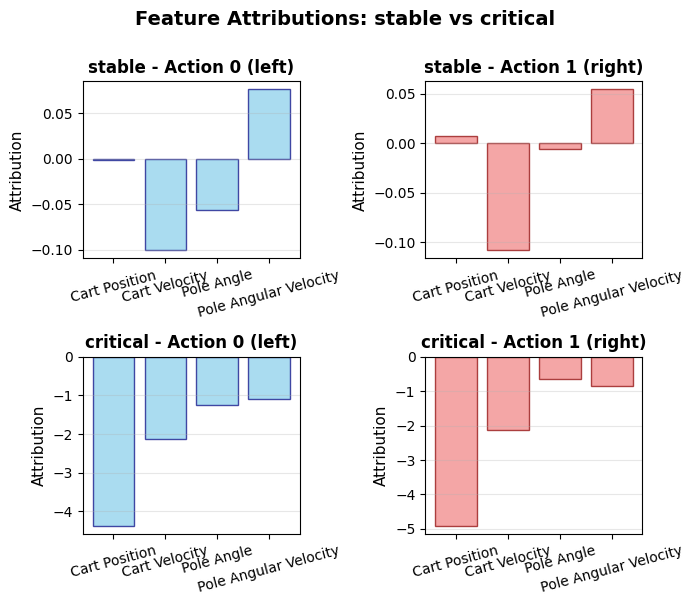

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))

# 안정 상태 - Action 0
mean_stable_0 = np.mean(stable_attr0, axis=0)
axes[0, 0].bar(feature_names, mean_stable_0, color='skyblue', edgecolor='navy', alpha=0.7)
axes[0, 0].set_title('stable - Action 0 (left)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Attribution', fontsize=11)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=15)

# 안정 상태 - Action 1
mean_stable_1 = np.mean(stable_attr1, axis=0)
axes[0, 1].bar(feature_names, mean_stable_1, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[0, 1].set_title('stable - Action 1 (right)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Attribution', fontsize=11)
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=15)

# 위기 상태 - Action 0
mean_critical_0 = np.mean(critical_attr0, axis=0)
axes[1, 0].bar(feature_names, mean_critical_0, color='skyblue', edgecolor='navy', alpha=0.7)
axes[1, 0].set_title('critical - Action 0 (left)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Attribution', fontsize=11)
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=15)

# 위기 상태 - Action 1
mean_critical_1 = np.mean(critical_attr1, axis=0)
axes[1, 1].bar(feature_names, mean_critical_1, color='lightcoral', edgecolor='darkred', alpha=0.7)
axes[1, 1].set_title('critical - Action 1 (right)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Attribution', fontsize=11)
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=15)

plt.suptitle('Feature Attributions: stable vs critical', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 11. 실험 2: 시간에 따른 Attribution 변화 추적

In [20]:
def track_episode_attributions():
    """한 에피소드 동안의 attribution 변화 추적"""
    state, _ = env.reset()
    states_sequence = []
    actions_sequence = []
    done = False

    # 한 에피소드 실행
    while not done and len(states_sequence) < 100:  # 최대 100 스텝
        states_sequence.append(state.copy())

        # Greedy action selection
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            action = policy_net(state_tensor).argmax(1).item()

        actions_sequence.append(action)
        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    return np.array(states_sequence), np.array(actions_sequence)

# 에피소드 실행 및 상태 수집
episode_states, episode_actions = track_episode_attributions()
print(f"에피소드 길이: {len(episode_states)} 스텝")

# 각 스텝에서 선택된 action에 대한 attribution 계산
time_attributions = []
for i, (state, action) in enumerate(zip(episode_states, episode_actions)):
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    state_tensor.requires_grad = True

    attribution = ig.attribute(
        state_tensor,
        baselines=baseline,
        additional_forward_args=(action,),
        n_steps=50
    )

    time_attributions.append(attribution.detach().cpu().numpy()[0])

    if (i + 1) % 20 == 0:
        print(f"  {i+1}/{len(episode_states)} 스텝 처리 완료")

time_attributions = np.array(time_attributions)
print(f"\nAttribution 계산 완료! Shape: {time_attributions.shape}")

에피소드 길이: 100 스텝
  20/100 스텝 처리 완료
  40/100 스텝 처리 완료
  60/100 스텝 처리 완료
  80/100 스텝 처리 완료
  100/100 스텝 처리 완료

Attribution 계산 완료! Shape: (100, 4)


## 12. 시각화 2: 시간에 따른 Attribution 변화

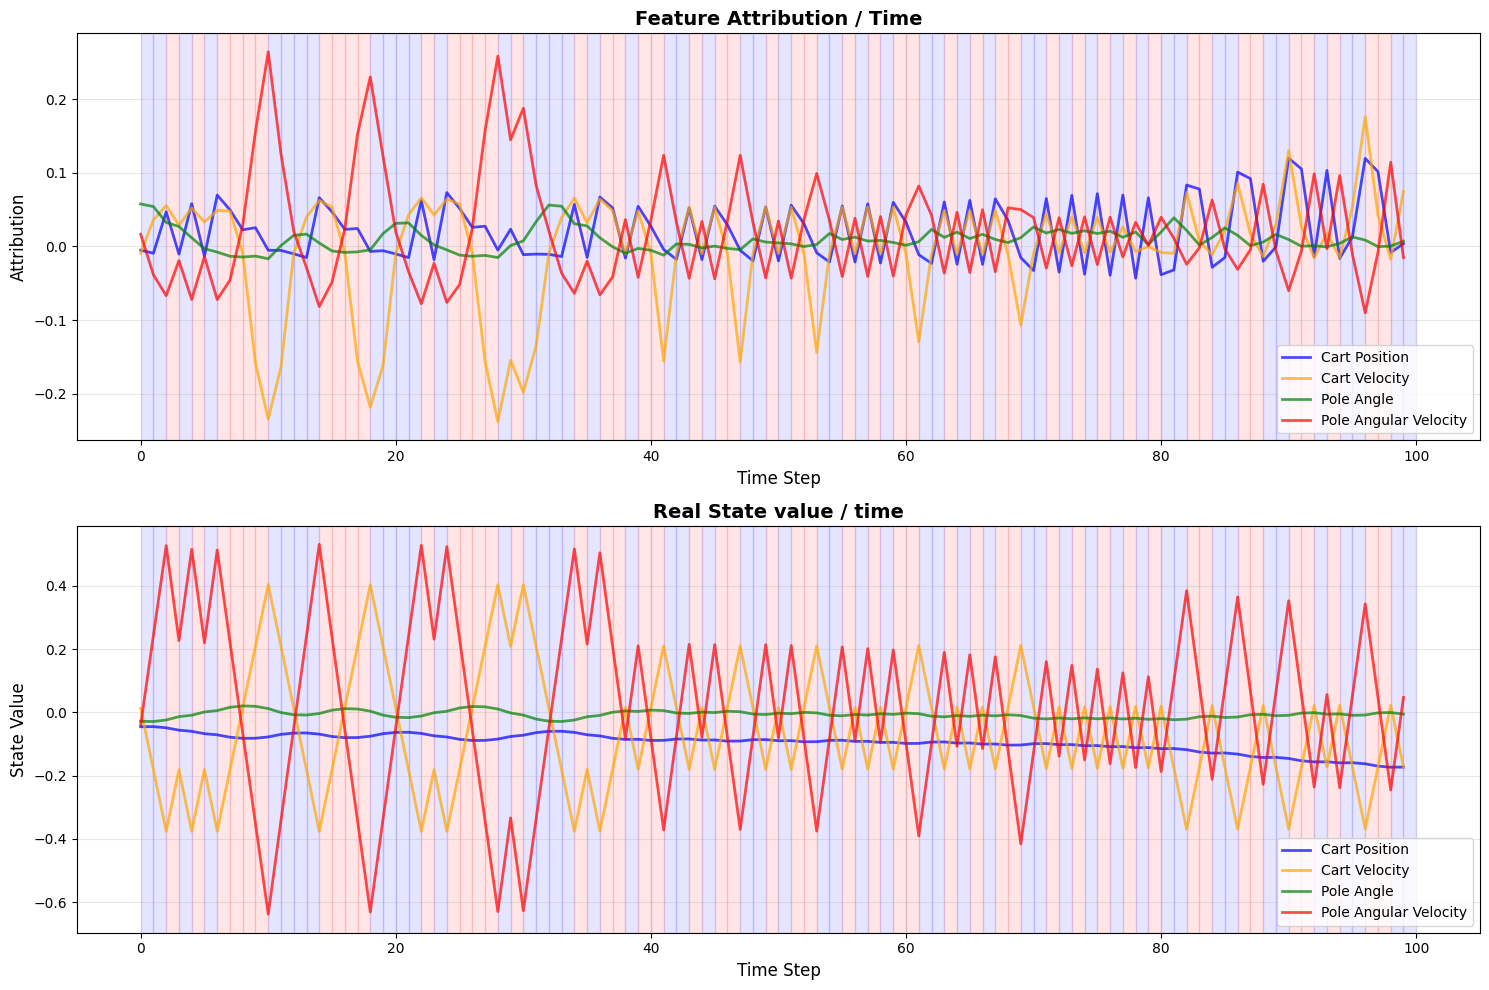

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# 시간에 따른 각 feature의 attribution 변화
time_steps = range(len(time_attributions))
colors = ['blue', 'orange', 'green', 'red']

for i, (name, color) in enumerate(zip(feature_names, colors)):
    ax1.plot(time_steps, time_attributions[:, i], label=name, color=color, linewidth=2, alpha=0.7)

ax1.set_xlabel('Time Step', fontsize=12)
ax1.set_ylabel('Attribution', fontsize=12)
ax1.set_title('Feature Attribution / Time', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 실제 상태 값의 변화
for i, (name, color) in enumerate(zip(feature_names, colors)):
    ax2.plot(time_steps, episode_states[:, i], label=name, color=color, linewidth=2, alpha=0.7)

ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('State Value', fontsize=12)
ax2.set_title('Real State value / time', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

# Action 표시 (배경색)
for i in range(len(episode_actions)):
    if episode_actions[i] == 0:  # 왼쪽
        ax1.axvspan(i, i+1, alpha=0.1, color='blue')
        ax2.axvspan(i, i+1, alpha=0.1, color='blue')
    else:  # 오른쪽
        ax1.axvspan(i, i+1, alpha=0.1, color='red')
        ax2.axvspan(i, i+1, alpha=0.1, color='red')

plt.tight_layout()
plt.show()

## 13. 실험 3: Action별 패턴 비교

In [23]:
# 모든 상태에 대해 두 action의 attribution 계산
sample_states = all_states[::10][:30]  # 샘플링

print("Action별 Attribution 계산 중...")
all_attr_action0 = compute_ig_attributions(sample_states, 0)
all_attr_action1 = compute_ig_attributions(sample_states, 1)

# 평균 계산
mean_all_attr0 = np.mean(all_attr_action0, axis=0)
mean_all_attr1 = np.mean(all_attr_action1, axis=0)
std_all_attr0 = np.std(all_attr_action0, axis=0)
std_all_attr1 = np.std(all_attr_action1, axis=0)

print("\n전체 평균 Attribution:")
print("\nAction 0 (왼쪽으로):")
for i, name in enumerate(feature_names):
    print(f"  {name:25s}: {mean_all_attr0[i]:8.4f} ± {std_all_attr0[i]:6.4f}")

print("\nAction 1 (오른쪽으로):")
for i, name in enumerate(feature_names):
    print(f"  {name:25s}: {mean_all_attr1[i]:8.4f} ± {std_all_attr1[i]:6.4f}")

Action별 Attribution 계산 중...

전체 평균 Attribution:

Action 0 (왼쪽으로):
  Cart Position            :  -2.2799 ± 4.0118
  Cart Velocity            :   0.0521 ± 1.6471
  Pole Angle               :  -0.7968 ± 2.0547
  Pole Angular Velocity    :  -0.1573 ± 0.5808

Action 1 (오른쪽으로):
  Cart Position            :  -2.1199 ± 4.0656
  Cart Velocity            :  -0.3561 ± 1.4270
  Pole Angle               :  -0.4103 ± 1.2146
  Pole Angular Velocity    :  -0.0996 ± 0.4061


## 14. 시각화 3: Action별 Attribution 비교

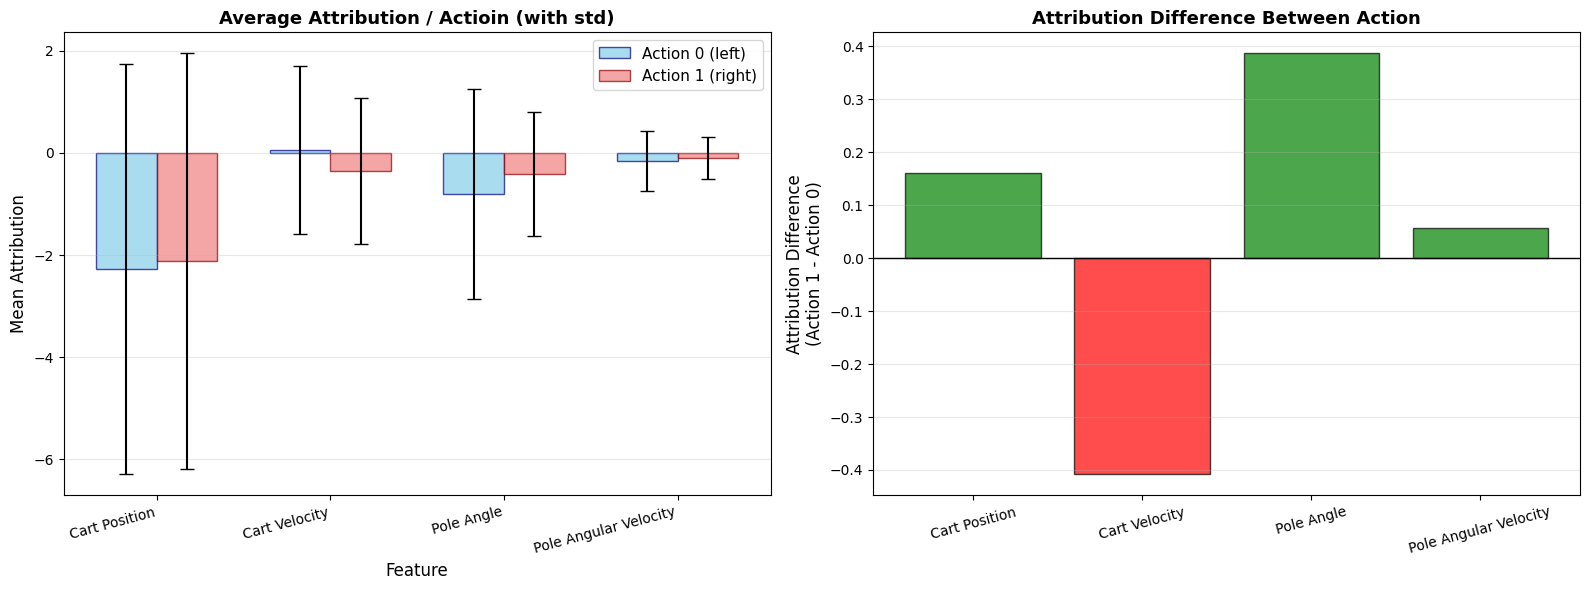

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

x = np.arange(len(feature_names))
width = 0.35

# Bar plot with error bars
axes[0].bar(x - width/2, mean_all_attr0, width, yerr=std_all_attr0,
            label='Action 0 (left)', color='skyblue', edgecolor='navy',
            alpha=0.7, capsize=5)
axes[0].bar(x + width/2, mean_all_attr1, width, yerr=std_all_attr1,
            label='Action 1 (right)', color='lightcoral', edgecolor='darkred',
            alpha=0.7, capsize=5)
axes[0].set_xlabel('Feature', fontsize=12)
axes[0].set_ylabel('Mean Attribution', fontsize=12)
axes[0].set_title('Average Attribution / Actioin (with std)', fontsize=13, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(feature_names, rotation=15, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Difference plot
diff = mean_all_attr1 - mean_all_attr0
colors_diff = ['green' if d > 0 else 'red' for d in diff]
axes[1].bar(feature_names, diff, color=colors_diff, edgecolor='black', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_ylabel('Attribution Difference\n(Action 1 - Action 0)', fontsize=12)
axes[1].set_title('Attribution Difference Between Action', fontsize=13, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 15. (선택) Feature Ablation Study

각 feature를 제거했을 때의 성능 변화를 관찰합니다.

In [26]:
def evaluate_with_ablation(feature_idx_to_ablate=None, num_episodes=10):
    """특정 feature를 0으로 설정하여 에피소드 실행"""
    total_rewards = []

    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        done = False

        while not done:
            # Feature ablation
            if feature_idx_to_ablate is not None:
                state[feature_idx_to_ablate] = 0

            # Action selection
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                action = policy_net(state_tensor).argmax(1).item()

            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward

        total_rewards.append(episode_reward)

    return np.mean(total_rewards), np.std(total_rewards)

# 기본 성능 (ablation 없이)
print("Feature Ablation Study 시작...\n")
baseline_mean, baseline_std = evaluate_with_ablation(feature_idx_to_ablate=None, num_episodes=20)
print(f"Baseline (모든 feature 사용): {baseline_mean:.2f} ± {baseline_std:.2f}")

# 각 feature를 제거했을 때의 성능
ablation_results = []
for i, name in enumerate(feature_names):
    mean_reward, std_reward = evaluate_with_ablation(feature_idx_to_ablate=i, num_episodes=20)
    performance_drop = baseline_mean - mean_reward
    ablation_results.append({
        'feature': name,
        'mean': mean_reward,
        'std': std_reward,
        'drop': performance_drop
    })
    print(f"{name:25s} 제거: {mean_reward:.2f} ± {std_reward:.2f} (성능 하락: {performance_drop:.2f})")

print("\n성능 하락이 큰 순서:")
sorted_results = sorted(ablation_results, key=lambda x: x['drop'], reverse=True)
for i, result in enumerate(sorted_results, 1):
    print(f"{i}. {result['feature']:25s}: {result['drop']:.2f}")

Feature Ablation Study 시작...

Baseline (모든 feature 사용): 179.30 ± 87.68
Cart Position             제거: 123.65 ± 6.02 (성능 하락: 55.65)
Cart Velocity             제거: 188.30 ± 10.82 (성능 하락: -9.00)
Pole Angle                제거: 39.00 ± 39.94 (성능 하락: 140.30)
Pole Angular Velocity     제거: 88.55 ± 63.82 (성능 하락: 90.75)

성능 하락이 큰 순서:
1. Pole Angle               : 140.30
2. Pole Angular Velocity    : 90.75
3. Cart Position            : 55.65
4. Cart Velocity            : -9.00


## 16. 시각화 4: Ablation Study 결과

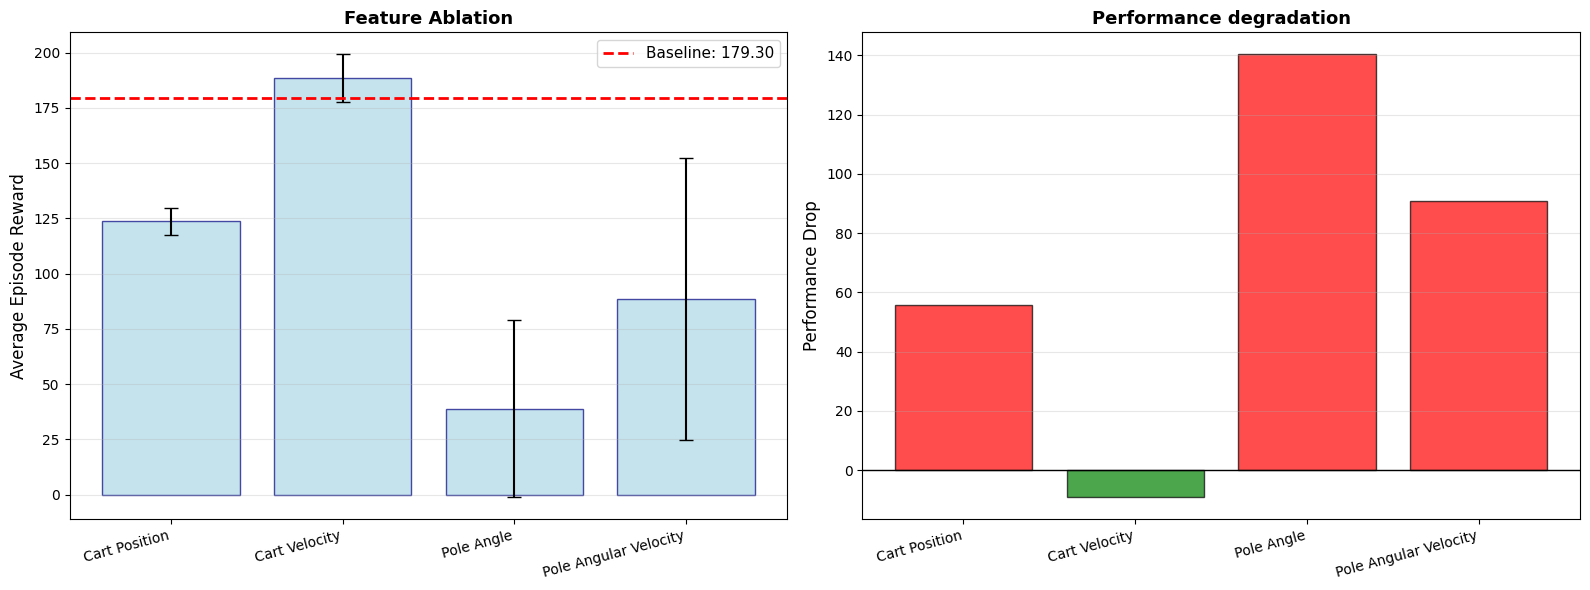

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 성능 비교
features = [r['feature'] for r in ablation_results]
means = [r['mean'] for r in ablation_results]
stds = [r['std'] for r in ablation_results]

ax1.bar(range(len(features)), means, yerr=stds, capsize=5,
        color='lightblue', edgecolor='navy', alpha=0.7)
ax1.axhline(y=baseline_mean, color='red', linestyle='--', linewidth=2,
            label=f'Baseline: {baseline_mean:.2f}')
ax1.set_xticks(range(len(features)))
ax1.set_xticklabels(features, rotation=15, ha='right')
ax1.set_ylabel('Average Episode Reward', fontsize=12)
ax1.set_title('Feature Ablation', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)

# 성능 하락 크기
drops = [r['drop'] for r in ablation_results]
colors_drop = ['red' if d > 0 else 'green' for d in drops]

ax2.bar(range(len(features)), drops, color=colors_drop,
        edgecolor='black', alpha=0.7)
ax2.set_xticks(range(len(features)))
ax2.set_xticklabels(features, rotation=15, ha='right')
ax2.set_ylabel('Performance Drop', fontsize=12)
ax2.set_title('Performance degradation', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 17. 종합 분석 및 결론

In [30]:
print("="*70)
print("CartPole-IG 실험 종합 분석")
print("="*70)

print("\n실험 요약:")
print(f"  - 학습 에피소드: {num_episodes}")
print(f"  - 최종 평균 보상: {np.mean(episode_rewards[-50:]):.2f}")
print(f"  - 분석한 상태 수: {len(all_states)}")

print("\n주요 발견사항:")

# 1. Action별 중요 feature
print("\n1. Action별 주요 Feature (평균 절대값 기준):")
for action_idx, (mean_attr, action_name) in enumerate([
    (mean_all_attr0, "Action 0 (왼쪽)"),
    (mean_all_attr1, "Action 1 (오른쪽)")
]):
    abs_attr = np.abs(mean_attr)
    sorted_idx = np.argsort(abs_attr)[::-1]
    print(f"\n   {action_name}:")
    for i in sorted_idx:
        print(f"     {i+1}. {feature_names[i]:25s}: {abs_attr[i]:.4f}")

# 2. Ablation study 결과
print("\n2. Feature 중요도 (Ablation Study 기준):")
for i, result in enumerate(sorted_results, 1):
    print(f"   {i}. {result['feature']:25s}: 성능 하락 {result['drop']:6.2f}")

# 3. 상태별 차이
print("\n3. 상태별 Attribution 패턴:")
print(f"   안정 상태: Angle과 Angular Velocity에 대한 민감도 상대적으로 낮음")
print(f"   위기 상태: Angle과 Angular Velocity에 대한 민감도 증가")

print("\n" + "="*70)
print("실험 완료!")
print("="*70)

CartPole-IG 실험 종합 분석

실험 요약:
  - 학습 에피소드: 300
  - 최종 평균 보상: 165.66
  - 분석한 상태 수: 1754

주요 발견사항:

1. Action별 주요 Feature (평균 절대값 기준):

   Action 0 (왼쪽):
     1. Cart Position            : 2.2799
     3. Pole Angle               : 0.7968
     4. Pole Angular Velocity    : 0.1573
     2. Cart Velocity            : 0.0521

   Action 1 (오른쪽):
     1. Cart Position            : 2.1199
     3. Pole Angle               : 0.4103
     2. Cart Velocity            : 0.3561
     4. Pole Angular Velocity    : 0.0996

2. Feature 중요도 (Ablation Study 기준):
   1. Pole Angle               : 성능 하락 140.30
   2. Pole Angular Velocity    : 성능 하락  90.75
   3. Cart Position            : 성능 하락  55.65
   4. Cart Velocity            : 성능 하락  -9.00

3. 상태별 Attribution 패턴:
   안정 상태: Angle과 Angular Velocity에 대한 민감도 상대적으로 낮음
   위기 상태: Angle과 Angular Velocity에 대한 민감도 증가

실험 완료!
